## Consumer Discretionary Model

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import quandl
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae
from functools import reduce


### Load target variable data

In [2]:
# Load P/E ratio -- data manually downloaded from Capital IQ
pe_ratio = pd.read_csv('../../data/raw/con_disc_pe_ratio.csv')
pe_ratio.head()

,Dates,S&P 500 Consumer Discretionary (Sector) (^SP500-25) - P/Normalized EPS
0,Aug-21-2001,31.70x
1,Aug-22-2001,31.80x
2,Aug-23-2001,31.69x
3,Aug-24-2001,32.48x
4,Aug-27-2001,32.17x


In [3]:
# load consumer discretionary index price -- also from Capital IQ
price = pd.read_csv('../../data/raw/con_disc_price.csv')
price.head()

,Dates,S&P 500 Consumer Discretionary (Sector) (^SP500-25) - Index Value
0,Sep-11-1989,77.33
1,Sep-12-1989,77.33
2,Sep-13-1989,76.32
3,Sep-14-1989,75.53
4,Sep-15-1989,75.66


In [4]:
# load 10 year treasury rate
quandl.ApiConfig.api_key = "_hLYTCZrYi9hepbQPNou"

treasury = quandl.get("FRED/DGS10")
treasury.head()

,Value
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


### Transform

In [5]:
# rename, change type
pe_ratio = pe_ratio.rename(columns = {"Dates": "Date", "S&P 500 Consumer Discretionary (Sector) (^SP500-25) - P/Normalized EPS" : "PE"})
pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'])
pe_ratio = pe_ratio.set_index('Date')

pe_ratio['PE'] = pe_ratio['PE'].str.rstrip('x')
pe_ratio['PE'] = pd.to_numeric(pe_ratio['PE'])
pe_ratio.head()

,PE
Date,
2001-08-21,31.70
2001-08-22,31.80
2001-08-23,31.69
2001-08-24,32.48
2001-08-27,32.17


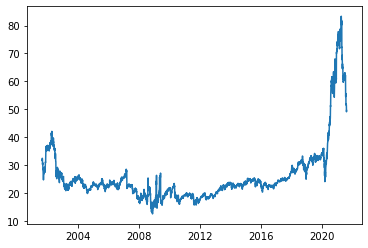

In [6]:
plt.plot(pe_ratio.PE)

In [7]:
# rename, change type
price = price.rename(columns = {"Dates": "Date", "S&P 500 Consumer Discretionary (Sector) (^SP500-25) - Index Value" : "Price"})
price['Date'] = pd.to_datetime(price['Date'])
price = price.set_index('Date')

price.head()

,Price
Date,
1989-09-11,77.33
1989-09-12,77.33
1989-09-13,76.32
1989-09-14,75.53
1989-09-15,75.66


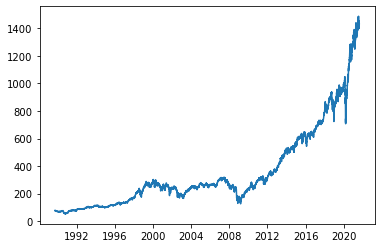

In [8]:
plt.plot(price.Price)

In [9]:
treasury = treasury.rename(columns = {"Value" : "treasury_rate"})
treasury.head()

,treasury_rate
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


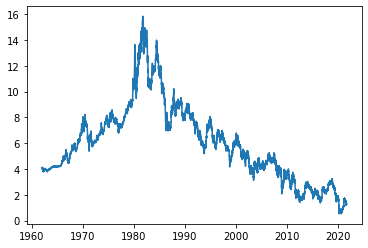

In [10]:
plt.plot(treasury.treasury_rate)

### Transform to monthly average

In [11]:
target_joined = pe_ratio.join(price).join(treasury)
target_joined.head()

,PE,Price,treasury_rate
Date,,,
2001-08-21,31.70,241.08,4.87
2001-08-22,31.80,241.63,4.91
2001-08-23,31.69,240.75,4.89
2001-08-24,32.48,246.84,4.93
2001-08-27,32.17,245.02,4.94


In [12]:
target_joined['month'] = target_joined.index.month
target_joined['year'] = target_joined.index.year

target_joined = target_joined.groupby([target_joined.year, target_joined.month]).mean()
target_joined.head()

PE       Price  treasury_rate
year month                                      
2001 8      31.516667  239.642222       4.867778
     9      27.175333  204.901333       4.748667
     10     28.268696  211.766087       4.566818
     11     33.669524  230.619524       4.651500
     12     36.054000  238.324500       5.087500

In [13]:
target_joined = target_joined.reset_index()
target_joined['date'] = pd.to_datetime(target_joined[['year', 'month']].assign(DAY=1))
target_joined = target_joined.set_index('date')
target_joined.head()

,year,month,PE,Price,treasury_rate
date,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778
2001-09-01,2001,9,27.175333,204.901333,4.748667
2001-10-01,2001,10,28.268696,211.766087,4.566818
2001-11-01,2001,11,33.669524,230.619524,4.651500
2001-12-01,2001,12,36.054000,238.324500,5.087500


In [14]:
target_joined['earnings'] = target_joined.Price / target_joined.PE
target_joined.head()

,year,month,PE,Price,treasury_rate,earnings
date,,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778,7.603666
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210


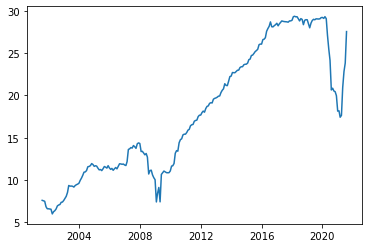

In [15]:
plt.plot(target_joined.earnings)

In [16]:
target_joined['earnings_change'] = target_joined.earnings.pct_change()
display(target_joined)

,year,month,PE,Price,treasury_rate,earnings,earnings_change
date,,,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778,7.603666,NaN
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975,-0.008376
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187,-0.006471
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504,-0.085658
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210,-0.034936
...,...,...,...,...,...,...,...
2021-04-01,2021,4,80.362500,1417.672000,1.628000,17.640964,0.012511
2021-05-01,2021,5,65.739500,1376.421500,1.621000,20.937511,0.186869
2021-06-01,2021,6,60.907368,1390.399474,1.524211,22.828100,0.090297


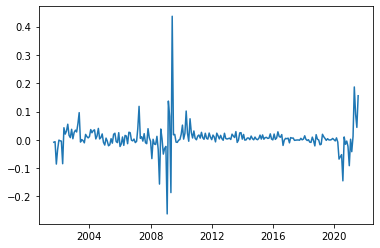

In [17]:
plt.plot(target_joined.earnings_change)

In [18]:
target_joined['target'] = target_joined.earnings_change - ((1 + target_joined.treasury_rate/100)**(1/12) - 1)
target_joined = target_joined.dropna()
target_joined.head()

,year,month,PE,Price,treasury_rate,earnings,earnings_change,target
date,,,,,,,,
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975,-0.008376,-0.012250
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187,-0.006471,-0.010199
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504,-0.085658,-0.089454
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210,-0.034936,-0.039080
2002-01-01,2002,1,36.128095,238.579524,5.035714,6.603712,-0.000983,-0.005086


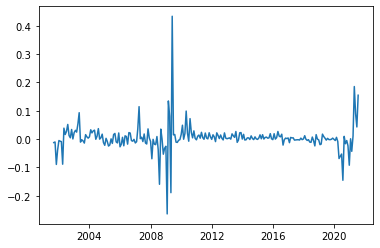

In [19]:
plt.plot(target_joined.target)

In [20]:
target = target_joined['target'].to_frame()
target.head()

,target
date,
2001-09-01,-0.012250
2001-10-01,-0.010199
2001-11-01,-0.089454
2001-12-01,-0.039080
2002-01-01,-0.005086


## Load exogenous Variables

In [21]:
def get_df_name(df):
    # grabs name of dataframe to be used as variable name
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def var_change(df):
    # creates year on year and month on month growth rate columns
    df_name = get_df_name(df)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df = df.set_index('Date')

    df = df.rename(columns = {'Value':df_name}).drop(columns = ['year', 'month'])

    df_mom_ch = df.rename(columns = {df_name : df_name + '_mom_ch'})
    df_mom_ch = df_mom_ch[df_name + '_mom_ch'].diff(1)/ df_mom_ch[df_name + '_mom_ch']

    df_yoy_ch = df.rename(columns = {df_name : df_name + '_yoy_ch'})
    df_yoy_ch = df_yoy_ch[df_name + '_yoy_ch'].diff(12)/ df_yoy_ch[df_name + '_yoy_ch']

    df_final = pd.DataFrame(df_mom_ch).join(df_yoy_ch).join(df)
    
    return df_final

## Load Quandl indicators

In [22]:
# PCEPILFE - Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index) 
pce = quandl.get('FRED/PCEPILFE')
pce.head()

,Value
Date,
1959-01-01,16.688
1959-02-01,16.701
1959-03-01,16.719
1959-04-01,16.762
1959-05-01,16.783


In [23]:
# CPIAUCSL - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 
cpi = quandl.get('FRED/CPIAUCSL')
cpi.head()

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [24]:
# UNRATE - Unemployment Rate 
unemp = quandl.get('FRED/UNRATE')
unemp.head()

,Value
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [25]:
# PAYEMS - All Employees, Total Nonfarm
emp = quandl.get('FRED/PAYEMS')
emp.head()

,Value
Date,
1939-01-01,29923.0
1939-02-01,30100.0
1939-03-01,30280.0
1939-04-01,30094.0
1939-05-01,30299.0


In [26]:
# RRSFS - Advance Real Retail and Food Services Sales
rrfs = quandl.get('FRED/RRSFS')
rrfs.head()

,Value
Date,
1992-01-01,118651.0
1992-02-01,118480.0
1992-03-01,117700.0
1992-04-01,118156.0
1992-05-01,118548.0


In [27]:
# RSXFS - Advance Retail Sales: Retail Trade
rsxfs = quandl.get('FRED/RSXFS')
rsxfs.head()

,Value
Date,
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0


In [28]:
# SOC1 - Consumer Sentiment
soc = quandl.get('UMICH/SOC1').rename(columns = {'Index':'Value'})
soc.head()

,Value
Date,
1952-11-30,86.2
1953-02-28,90.7
1953-08-31,80.8
1953-11-30,80.7
1954-02-28,82.0


In [29]:
# FRED/VXTYN - CBOE 10-Year Treasury Note Volatility Futures
# https://fred.stlouisfed.org/series/VIXCLS#0
vix = pd.read_csv('../../data/raw/VIXCLS.csv').rename(columns = {'VIXCLS' : 'Value'})
vix['DATE'] = pd.to_datetime(vix['DATE'])
vix = vix.set_index('DATE')
vix.head()

,Value
DATE,
1990-01-01,23.347273
1990-02-01,23.262632
1990-03-01,20.062273
1990-04-01,21.403500
1990-05-01,18.097727


In [30]:
# FED/RXI_N_M_CH - CHINA -- SPOT EXCHANGE RATE, YUAN/US$, Monthly
usdcny = quandl.get('FED/RXI_N_M_CH')
usdcny.head()

,Value
Date,
1981-01-31,1.5518
1981-02-28,1.6131
1981-03-31,1.6314
1981-04-30,1.6660
1981-05-31,1.7270


In [31]:
# find month-on-month growth and year-on-year growth
emp_new = var_change(emp)
pce_new = var_change(pce)
cpi_new = var_change(cpi)
unemp_new = var_change(unemp)
rrfs_new = var_change(rrfs)
rsxfs_new = var_change(rsxfs)
soc_new = var_change(soc)
vix_new = var_change(vix)
usdcny_new = var_change(usdcny)

### Joined exogenous dataframe

In [32]:
# join all exogenous variables
ex_list = [emp_new, pce_new, cpi_new, unemp_new, rrfs_new, rsxfs_new, soc_new, vix_new, usdcny_new]
ex_merged = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), ex_list)
ex_merged.head()

,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,unemp_mom_ch,...,rsxfs,soc_mom_ch,soc_yoy_ch,soc,vix_mom_ch,vix_yoy_ch,vix,usdcny_mom_ch,usdcny_yoy_ch,usdcny
Date,,,,,,,,,,,,,,,,,,,,,
1939-01-01,NaN,NaN,29923.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-02-01,0.005880,NaN,30100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-01,0.005945,NaN,30280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-04-01,-0.006181,NaN,30094.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-05-01,0.006766,NaN,30299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
ex_final = ex_merged
ex_final.columns

Index(['emp_mom_ch', 'emp_yoy_ch', 'emp', 'pce_mom_ch', 'pce_yoy_ch', 'pce',
       'cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'unemp_mom_ch', 'unemp_yoy_ch',
       'unemp', 'rrfs_mom_ch', 'rrfs_yoy_ch', 'rrfs', 'rsxfs_mom_ch',
       'rsxfs_yoy_ch', 'rsxfs', 'soc_mom_ch', 'soc_yoy_ch', 'soc',
       'vix_mom_ch', 'vix_yoy_ch', 'vix', 'usdcny_mom_ch', 'usdcny_yoy_ch',
       'usdcny'],
      dtype='object')

### Create feature lags

In [34]:
# this lags features in ex_columns in the range of periods in lag_periods

ex_columns = ['emp_mom_ch', 'emp_yoy_ch', 'emp', 'pce_mom_ch', 'pce_yoy_ch', 'pce',
       'cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'unemp_mom_ch', 'unemp_yoy_ch',
       'unemp', 'rrfs_mom_ch', 'rrfs_yoy_ch', 'rrfs', 'rsxfs_mom_ch',
       'rsxfs_yoy_ch', 'rsxfs', 'soc_mom_ch', 'soc_yoy_ch', 'soc',
       'vix_mom_ch', 'vix_yoy_ch', 'vix',  'usdcny_mom_ch', 'usdcny_yoy_ch',
       'usdcny']

lag_periods = list(range(1,14))
def add_lags(var_names, lag_periods):
    for var in var_names:
        for lag in lag_periods:
            var_col = var + '_' + str(lag)
            ex_final[var_col] = ex_final[var].shift(lag)
            
add_lags(ex_columns, lag_periods)

<ipython-input-34-003879ab145d>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ex_final[var_col] = ex_final[var].shift(lag)


## Join with target variable

In [35]:
# join all exogenous variables
final_join_list = [target, ex_final]
final_df = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), final_join_list)
final_df

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
1939-01-01,NaN,NaN,NaN,29923.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-02-01,NaN,0.005880,NaN,30100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-01,NaN,0.005945,NaN,30280.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-04-01,NaN,-0.006181,NaN,30094.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-05-01,NaN,0.006766,NaN,30299.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,0.011165,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205
2021-05-01,0.185528,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708
2021-06-01,0.089035,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4601,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016
2021-07-01,0.042853,0.006423,0.049414,146821.0,0.003364,0.034913,117.720,0.004716,0.050175,272.265,...,6.5109,6.4601,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816


In [36]:
# look at any NAs
final_df[final_df.isna().any(1)]

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
1939-01-01,NaN,NaN,NaN,29923.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-02-01,NaN,0.005880,NaN,30100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-01,NaN,0.005945,NaN,30280.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-04-01,NaN,-0.006181,NaN,30094.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-05-01,NaN,0.006766,NaN,30299.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-05-01,NaN,-0.000400,0.002303,132410.0,0.000232,0.019044,81.970,0.005076,0.034405,177.3,...,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,8.2793
2001-06-01,NaN,-0.000839,0.001799,132299.0,0.002240,0.020498,82.154,0.002251,0.030951,177.7,...,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781
2001-07-01,NaN,-0.000923,-0.000446,132177.0,0.002574,0.020785,82.366,-0.001691,0.026494,177.4,...,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772
2001-08-01,NaN,-0.001129,-0.001530,132028.0,0.000485,0.020011,82.406,0.000000,0.026494,177.4,...,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794


In [37]:
# rename index
df = final_df
df.index = df.index.rename('date')
df

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
date,,,,,,,,,,,,,,,,,,,,,
1939-01-01,NaN,NaN,NaN,29923.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-02-01,NaN,0.005880,NaN,30100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-01,NaN,0.005945,NaN,30280.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-04-01,NaN,-0.006181,NaN,30094.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-05-01,NaN,0.006766,NaN,30299.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,0.011165,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205
2021-05-01,0.185528,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708
2021-06-01,0.089035,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4601,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016


## Write data

In [81]:
df.to_csv('../../data/final/consumer_discretionary_data.csv')

## Feature Correlation

In [38]:
var_corr = (df.corr().sort_values('target'))
var_corr.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
unemp_13,0.292828,0.105200,0.251878,0.204087,0.092280,0.138790,0.064860,0.115575,0.129274,0.206116,...,-0.508931,-0.509759,-0.508892,-0.506977,-0.503972,-0.500841,-0.497994,-0.495445,-0.492900,-0.491490
unemp_yoy_ch_13,0.297173,0.051349,-0.036677,-0.032754,0.028740,0.102081,-0.069995,0.026098,-0.045574,-0.020256,...,-0.090841,-0.083770,-0.073465,-0.061767,-0.048516,-0.036873,-0.025369,-0.015857,-0.005497,0.003109
soc_yoy_ch,0.297678,0.166865,0.278958,-0.010014,-0.074400,-0.100192,0.027067,-0.115729,-0.251676,0.011471,...,-0.123869,-0.119559,-0.117416,-0.116759,-0.116274,-0.119389,-0.123010,-0.132997,-0.133297,-0.132805
soc_yoy_ch_1,0.320544,0.090834,0.306169,-0.009428,-0.095514,-0.101853,0.024563,-0.094651,-0.241424,0.008797,...,-0.128380,-0.123869,-0.119559,-0.117416,-0.116759,-0.116274,-0.119389,-0.123010,-0.132997,-0.133297
target,1.000000,-0.016757,0.188015,-0.069599,0.040804,0.068764,-0.041159,0.117952,-0.016361,-0.037562,...,-0.034077,-0.036086,-0.038263,-0.039486,-0.040882,-0.039401,-0.034582,-0.033218,-0.029852,-0.024470


In [39]:
var_corr.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
emp_yoy_ch_13,-0.337812,0.007171,0.167818,-0.237498,0.209448,0.202588,-0.273379,0.099552,0.261887,-0.236790,...,-0.004658,-0.007067,-0.012159,-0.019999,-0.029295,-0.038339,-0.047281,-0.055504,-0.062729,-0.068647
cpi_mom_ch_7,-0.330415,-0.032683,0.098289,-0.086893,0.562618,0.664965,-0.257304,0.353229,0.687727,-0.158182,...,-0.265824,-0.258809,-0.249996,-0.240525,-0.227575,-0.218252,-0.212800,-0.206367,-0.199229,-0.190717
unemp_yoy_ch_1,-0.311987,-0.132587,-0.827806,-0.018373,0.102371,0.160262,-0.009330,-0.083359,-0.040981,-0.011528,...,0.023976,0.027098,0.029725,0.031206,0.029851,0.028759,0.028331,0.029896,0.032971,0.038319
emp_yoy_ch_12,-0.295723,0.013263,0.197128,-0.240931,0.185426,0.187531,-0.282548,0.112259,0.266107,-0.249519,...,-0.008181,-0.013164,-0.020680,-0.029856,-0.039038,-0.048088,-0.056661,-0.064107,-0.070390,-0.075686
unemp_yoy_ch,-0.264545,-0.256607,-0.857687,-0.022993,0.074269,0.163028,-0.018328,-0.110512,-0.020108,-0.020111,...,0.027098,0.029725,0.031206,0.029851,0.028759,0.028331,0.029896,0.032971,0.038319,0.043855


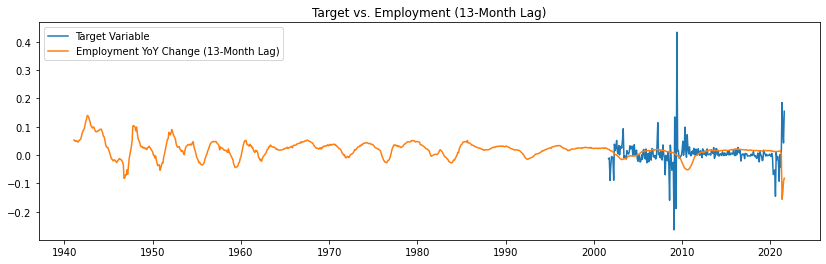

In [40]:
plt.figure(figsize = (14, 4))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.emp_yoy_ch_13, label = 'Employment YoY Change (13-Month Lag)')
plt.title('Target vs. Employment (13-Month Lag)')
plt.legend()

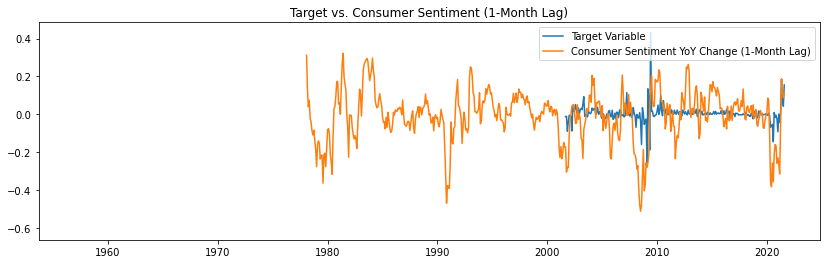

In [41]:
plt.figure(figsize = (14, 4))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.soc_yoy_ch_1, label = 'Consumer Sentiment YoY Change (1-Month Lag)')
plt.title('Target vs. Consumer Sentiment (1-Month Lag)')
plt.legend()

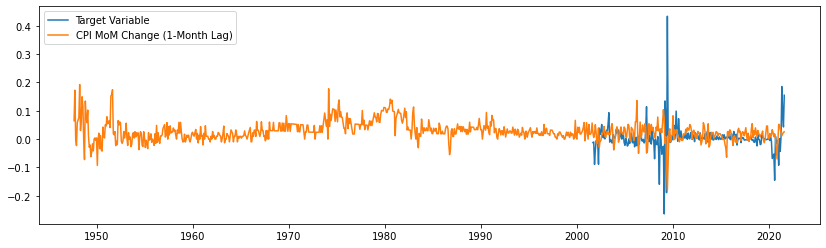

In [42]:
plt.figure(figsize = (14, 4))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.cpi_mom_ch_7*10, label = 'CPI MoM Change (1-Month Lag)')
plt.legend()

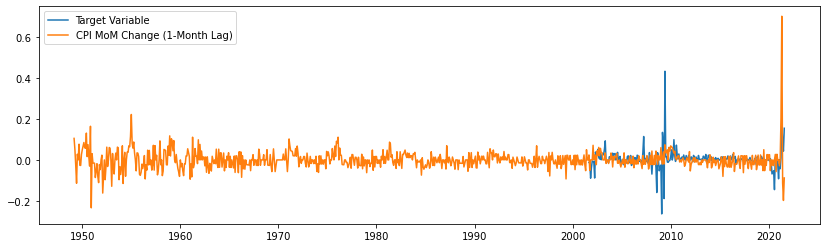

In [43]:
plt.figure(figsize = (14, 4))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.unemp_mom_ch_13, label = 'CPI MoM Change (1-Month Lag)')
plt.legend()

Notes:
- we would include highest and lowest correlation features
- in 1-2 months ahead, soc and unemp have large correlation
- around half year: cpi has large correlation
- 10-plus periods: unemp and emp 

## Shift target variables for 1, 3, 6, 12, 18 months

In [44]:
df_1 = df
df_1 = df_1.reset_index()
df_1['target'] = df_1.target.shift(-1)
df_1['date'] = df_1.date + pd.DateOffset(months = 1)
df_1 = df_1.set_index('date')
df_1 = df_1[df_1.index >= target.index[0]]
df_1['month'] = df_1.index.month
df_1

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,-0.001129,-0.001530,132028.0,0.000485,0.020011,82.406,0.000000,0.026494,177.400,...,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,9
2001-10-01,-0.010199,-0.001950,-0.004417,131771.0,-0.005699,0.012033,81.939,0.003930,0.025267,178.100,...,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,10
2001-11-01,-0.089454,-0.002411,-0.006824,131454.0,0.006993,0.017560,82.516,-0.002815,0.020833,177.600,...,8.2770,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,11
2001-12-01,-0.039080,-0.002379,-0.010782,131142.0,0.002020,0.017815,82.683,-0.000563,0.018592,177.500,...,8.2770,8.2770,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,12
2002-01-01,-0.005086,-0.001222,-0.013185,130982.0,0.000230,0.017085,82.702,-0.000564,0.015784,177.400,...,8.2769,8.2770,8.2770,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,0.185528,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205,5
2021-06-01,0.089035,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,6
2021-07-01,0.042853,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7


In [45]:
df_3 = df
df_3 = df_3.reset_index()
df_3['target'] = df_3.target.shift(-3)
df_3['date'] = df_3.date + pd.DateOffset(months = 3)
df_3 = df_3.set_index('date')
df_3 = df_3[df_3.index >= target.index[0]]
df_3['month'] = df_3.index.month
df_3

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,-0.000839,0.001799,132299.0,0.002240,0.020498,82.154,0.002251,0.030951,177.700,...,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,9
2001-10-01,-0.010199,-0.000923,-0.000446,132177.0,0.002574,0.020785,82.366,-0.001691,0.026494,177.400,...,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,10
2001-11-01,-0.089454,-0.001129,-0.001530,132028.0,0.000485,0.020011,82.406,0.000000,0.026494,177.400,...,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,11
2001-12-01,-0.039080,-0.001950,-0.004417,131771.0,-0.005699,0.012033,81.939,0.003930,0.025267,178.100,...,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,12
2002-01-01,-0.005086,-0.002411,-0.006824,131454.0,0.006993,0.017560,82.516,-0.002815,0.020833,177.600,...,8.2770,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,0.042853,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205,7
2021-08-01,0.154848,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,8
2021-09-01,NaN,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,9


In [46]:
df_6 = df
df_6 = df_6.reset_index()
df_6['target'] = df_6.target.shift(-6)
df_6['date'] = df_6.date + pd.DateOffset(months = 6)
df_6 = df_6.set_index('date')
df_6 = df_6[df_6.index >= target.index[0]]
df_6['month'] = df_6.index.month
df_6

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,-0.000316,0.008671,132747.0,0.001039,0.018956,81.821,0.000568,0.028961,176.100,...,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,8.2793,8.2786,8.2781,9
2001-10-01,-0.010199,-0.002144,0.004341,132463.0,0.001586,0.019866,81.951,0.001701,0.031179,176.400,...,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,8.2793,8.2786,10
2001-11-01,-0.089454,-0.000400,0.002303,132410.0,0.000232,0.019044,81.970,0.005076,0.034405,177.300,...,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,8.2793,11
2001-12-01,-0.039080,-0.000839,0.001799,132299.0,0.002240,0.020498,82.154,0.002251,0.030951,177.700,...,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,12
2002-01-01,-0.005086,-0.000923,-0.000446,132177.0,0.002574,0.020785,82.366,-0.001691,0.026494,177.400,...,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,NaN,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205,10
2021-11-01,NaN,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,11
2021-12-01,NaN,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,12


In [47]:
df_12 = df
df_12 = df_12.reset_index()
df_12['target'] = df_12.target.shift(-12)
df_12['date'] = df_12.date + pd.DateOffset(months = 12)
df_12 = df_12.set_index('date')
df_12 = df_12[df_12.index >= target.index[0]]
df_12['month'] = df_12.index.month
df_12

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,0.000929,0.019501,132353.0,0.002421,0.018159,80.953,0.005184,0.033410,173.600,...,8.2793,8.2786,8.2781,8.2792,8.2794,8.2782,8.2775,8.2774,8.2772,9
2001-10-01,-0.010199,-0.000015,0.016426,132351.0,0.001406,0.017862,81.067,0.001725,0.033353,173.900,...,8.2781,8.2793,8.2786,8.2781,8.2792,8.2794,8.2782,8.2775,8.2774,10
2001-11-01,-0.089454,0.001547,0.015767,132556.0,0.001761,0.018655,81.210,0.001722,0.033295,174.200,...,8.2772,8.2781,8.2793,8.2786,8.2781,8.2792,8.2794,8.2782,8.2775,11
2001-12-01,-0.039080,0.001153,0.014596,132709.0,0.000972,0.018367,81.289,0.002291,0.033219,174.600,...,8.2794,8.2772,8.2781,8.2793,8.2786,8.2781,8.2792,8.2794,8.2782,12
2002-01-01,-0.005086,-0.000083,0.012758,132698.0,0.003714,0.019671,81.592,0.005695,0.035877,175.600,...,8.2796,8.2794,8.2772,8.2781,8.2793,8.2786,8.2781,8.2792,8.2794,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,NaN,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205,4
2022-05-01,NaN,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,5
2022-06-01,NaN,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,6


In [48]:
df_18 = df
df_18 = df_18.reset_index()
df_18['target'] = df_18.target.shift(-18)
df_18['date'] = df_18.date + pd.DateOffset(months = 18)
df_18 = df_18.set_index('date')
df_18 = df_18[df_18.index >= target.index[0]]
df_18['month'] = df_18.index.month
df_18

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,0.003587,0.025601,131596.0,0.002043,0.018650,80.270,0.005848,0.036257,171.000,...,8.2775,8.2774,8.2772,8.2776,8.2780,8.2785,8.2792,8.2792,8.2781,9
2001-10-01,-0.010199,0.002214,0.024953,131888.0,0.000660,0.016782,80.323,-0.000585,0.029257,170.900,...,8.2782,8.2775,8.2774,8.2772,8.2776,8.2780,8.2785,8.2792,8.2792,10
2001-11-01,-0.089454,0.001643,0.024957,132105.0,0.001070,0.016889,80.409,0.001752,0.030374,171.200,...,8.2794,8.2782,8.2775,8.2774,8.2772,8.2776,8.2780,8.2785,8.2792,11
2001-12-01,-0.039080,-0.000333,0.022505,132061.0,0.000758,0.017124,80.470,0.005807,0.036005,172.200,...,8.2792,8.2794,8.2782,8.2775,8.2774,8.2772,8.2776,8.2780,8.2785,12
2002-01-01,-0.005086,0.001323,0.021341,132236.0,0.002281,0.017594,80.654,0.002895,0.034742,172.700,...,8.2781,8.2792,8.2794,8.2782,8.2775,8.2774,8.2772,8.2776,8.2780,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,NaN,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205,10
2022-11-01,NaN,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,11
2022-12-01,NaN,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,12


# Model

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from PlotForecast import plot_forecast

## SARIMA Model - 1 month

In [50]:
var_corr_1 = (df_1.corr().sort_values('target'))
var_corr_1.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
emp_yoy_ch_12,-0.337812,-0.026793,-0.084907,0.303421,-0.249757,-0.170194,0.059434,-0.176460,-0.164164,0.059529,...,-0.032351,-0.039720,-0.049553,-0.061769,-0.073730,-0.085350,-0.093759,-0.098108,-0.098221,0.000483
cpi_mom_ch_6,-0.330415,-0.037136,0.095128,-0.014800,0.029044,0.248974,-0.079179,-0.058678,0.334991,-0.069673,...,0.108040,0.114735,0.129191,0.140590,0.145870,0.146987,0.147123,0.148015,0.150161,-0.053192
unemp_yoy_ch,-0.311987,-0.195374,-0.899288,-0.309745,-0.296346,-0.535551,-0.197423,-0.170894,-0.349811,-0.208291,...,0.220751,0.220491,0.217688,0.211660,0.202998,0.196099,0.190651,0.188789,0.190429,0.011836
emp_yoy_ch_11,-0.295723,-0.027373,0.041462,0.286310,-0.251290,-0.119783,0.039171,-0.179630,-0.125747,0.041549,...,-0.033447,-0.042178,-0.054188,-0.067008,-0.079360,-0.089497,-0.095034,-0.096881,-0.096203,0.021414
emp_yoy_ch_13,-0.254766,-0.031860,-0.040952,0.325689,-0.171910,-0.143496,0.086473,-0.156639,-0.168595,0.083762,...,-0.035186,-0.039202,-0.047753,-0.057789,-0.069090,-0.080277,-0.090076,-0.097264,-0.099785,-0.016674


In [51]:
var_corr_1.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
soc_yoy_ch_1,0.285433,0.021363,0.373103,0.028178,-0.045453,-0.026288,0.060050,0.028127,-0.242123,0.053759,...,-0.193519,-0.207256,-0.220413,-0.232566,-0.240272,-0.244791,-0.249045,-0.253069,-0.256543,-0.011877
unemp_12,0.292828,0.080245,0.366365,-0.369485,0.129814,0.040144,0.010023,0.085047,0.088140,0.060049,...,-0.390887,-0.383255,-0.373609,-0.362119,-0.350385,-0.338670,-0.328488,-0.320996,-0.315820,-0.001919
unemp_yoy_ch_12,0.297173,-0.005223,-0.128942,-0.448615,0.156568,0.057278,-0.234086,0.124875,0.094711,-0.235962,...,0.174470,0.179844,0.189653,0.200304,0.210603,0.220698,0.229038,0.234431,0.237016,0.002264
soc_yoy_ch,0.320544,0.141838,0.384013,0.025248,0.102230,-0.006452,0.060468,0.021210,-0.275514,0.052765,...,-0.202004,-0.215297,-0.227580,-0.235380,-0.239968,-0.244291,-0.248377,-0.251912,-0.256677,-0.029808
target,1.000000,0.080206,0.228088,-0.046248,0.081717,0.117612,-0.014669,0.081267,0.018788,-0.013864,...,-0.038263,-0.039486,-0.040882,-0.039401,-0.034582,-0.033218,-0.029852,-0.024470,-0.026566,0.004023


In [52]:
model_exvar = ['soc_yoy_ch_1', 'emp_yoy_ch_12']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_1.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_1.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [53]:
# Find p, q for sarimax model
#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
#print(results.summary())

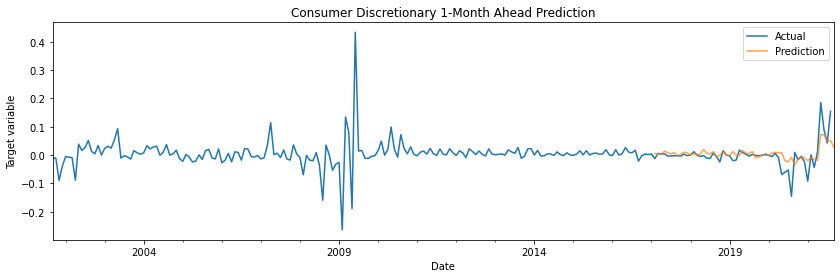

MAPE: 1.884
MAE: 0.018


In [54]:
# use orders from auto arima above
sar1_model = SARIMAX(y_train, 
                order = (3,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar1_mod_fit = sar1_model.fit()

sar1_pred = sar1_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

sar1_pred_mean = sar1_pred.predicted_mean
sar1_pred_ci = sar1_pred.conf_int(alpha = 0.5)
ax = df_1.target.plot(label='Actual')
sar1_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 1-Month Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar1_pred_mean[sar1_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar1_pred_mean[sar1_pred_mean.index < last_date]), 3))

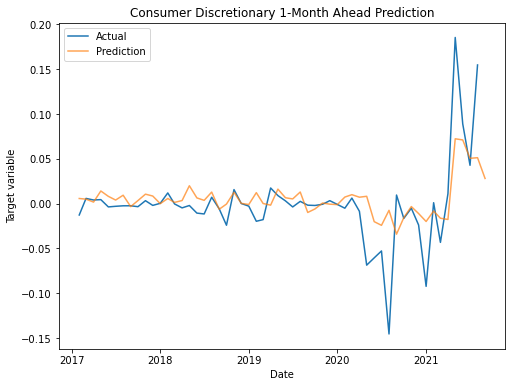

In [55]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_1[df_1.index >= first_date].index, df_1[df_1.index >= first_date].target, label = 'Actual')
ax.plot(sar1_pred_mean.index, sar1_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 1-Month Ahead Prediction')
plt.legend()
plt.show()

## SARIMAX Model - 3 month

In [56]:
var_corr_3 = (df_3.corr().sort_values('target'))
var_corr_3.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
emp_yoy_ch_10,-0.337812,-0.026569,0.163997,0.266238,-0.185624,-0.050287,0.011988,-0.162632,-0.071568,0.016230,...,-0.028173,-0.039109,-0.051697,-0.064800,-0.075623,-0.082820,-0.085857,-0.086880,-0.084702,-0.026878
cpi_mom_ch_4,-0.330415,0.020662,0.143507,0.009715,-0.018093,0.286966,-0.060054,-0.016942,0.352348,-0.047710,...,0.115432,0.126044,0.131822,0.134148,0.135896,0.138705,0.142585,0.147007,0.148515,-0.035305
emp_yoy_ch_9,-0.295723,-0.019054,0.251184,0.254104,-0.167491,-0.008497,-0.004074,-0.141595,-0.026510,0.002731,...,-0.033779,-0.045358,-0.058290,-0.069916,-0.077842,-0.082506,-0.084627,-0.084036,-0.085946,-0.005479
emp_yoy_ch_11,-0.254766,-0.027981,0.040770,0.280134,-0.245755,-0.114611,0.029049,-0.181446,-0.121212,0.030951,...,-0.024680,-0.033402,-0.045369,-0.058134,-0.070439,-0.080556,-0.086119,-0.088044,-0.087459,-0.045335
soc_10,-0.250923,-0.024191,0.101357,0.456843,0.020234,0.256227,0.059169,0.006233,0.205213,0.003881,...,0.370393,0.360241,0.349199,0.336381,0.322830,0.309694,0.297051,0.284268,0.271496,-0.081786


In [57]:
var_corr_3.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
unemp_9,0.268575,0.074946,0.063164,-0.408511,0.063429,-0.139679,0.018577,0.065548,-0.031686,0.063999,...,-0.361878,-0.349969,-0.338028,-0.327367,-0.319412,-0.313608,-0.308839,-0.306096,-0.300687,-0.016110
unemp_yoy_ch_9,0.270288,-0.014720,-0.338983,-0.370231,0.161558,-0.005915,-0.154463,0.120069,0.018217,-0.161284,...,0.164578,0.174733,0.186278,0.197872,0.206746,0.213674,0.218509,0.220516,0.222301,0.013145
unemp_10,0.292828,0.083977,0.156403,-0.389208,0.081573,-0.081504,0.023154,0.080828,0.012896,0.070120,...,-0.376348,-0.364948,-0.353060,-0.341149,-0.330530,-0.322617,-0.316894,-0.312187,-0.309556,0.004108
unemp_yoy_ch_10,0.297173,0.008797,-0.262462,-0.388370,0.157905,0.023487,-0.175344,0.120931,0.049210,-0.180514,...,0.163915,0.173398,0.184456,0.196115,0.206921,0.215098,0.220510,0.224335,0.224893,0.028534
target,1.000000,0.058837,0.068676,-0.074293,0.132679,-0.018850,-0.018791,0.160370,-0.073281,-0.021464,...,-0.040882,-0.039401,-0.034582,-0.033218,-0.029852,-0.024470,-0.026566,-0.026079,-0.025570,0.004023


In [58]:
model_exvar = ['emp_yoy_ch_10']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_3.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_3.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [59]:
sar3_model = SARIMAX(y_train, 
                order = (3,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar3_mod_fit = sar3_model.fit()

sar3_pred = sar3_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

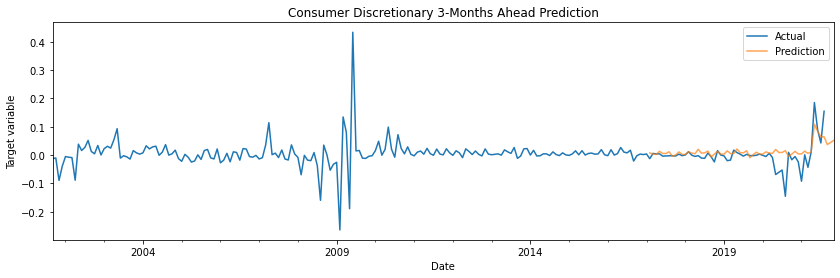

MAPE: 3.131
MAE: 0.02


In [60]:
sar3_pred_mean = sar3_pred.predicted_mean
sar3_pred_ci = sar3_pred.conf_int()
ax = df_3.target.plot(label='Actual')
sar3_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 3-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar3_pred_mean[sar3_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar3_pred_mean[sar3_pred_mean.index < last_date]), 3))

## SARIMAX Model - 6 month

In [61]:
var_corr_6 = (df_6.corr().sort_values('target'))
var_corr_6.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
emp_yoy_ch_7,-0.337812,-0.004369,0.372301,0.216030,-0.134801,0.051017,-0.048270,-0.107318,0.050741,-0.038594,...,-0.033255,-0.043652,-0.052294,-0.058639,-0.063282,-0.065615,-0.070248,-0.074593,-0.079710,-0.009245
cpi_mom_ch_1,-0.330415,0.114464,0.185980,0.038701,0.376218,0.332634,-0.012037,0.471791,0.409720,0.003330,...,0.114061,0.116047,0.120152,0.126049,0.132857,0.136900,0.136220,0.134347,0.132723,-0.045036
emp_yoy_ch_6,-0.295723,-0.010420,0.418141,0.199634,-0.094640,0.070780,-0.063767,-0.093339,0.076567,-0.052412,...,-0.038419,-0.046144,-0.052399,-0.057872,-0.060955,-0.067132,-0.072498,-0.079053,-0.084513,0.009407
emp_yoy_ch_8,-0.254766,-0.004465,0.320722,0.232849,-0.187102,0.025031,-0.033253,-0.124231,0.018234,-0.025039,...,-0.026839,-0.038651,-0.050049,-0.058821,-0.064311,-0.068189,-0.068861,-0.072419,-0.075234,-0.027330
soc_7,-0.250923,0.029844,0.200487,0.444935,0.058905,0.282785,0.046468,0.083383,0.199211,-0.009357,...,0.339666,0.326118,0.312884,0.299876,0.286730,0.273380,0.259747,0.244498,0.228227,-0.079886


In [62]:
var_corr_6.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
unemp_6,0.268575,0.060693,-0.141675,-0.442070,-0.038845,-0.277903,0.022431,0.018205,-0.150493,0.064126,...,-0.327701,-0.319705,-0.313945,-0.309206,-0.306486,-0.301048,-0.294634,-0.286137,-0.277005,-0.014996
unemp_yoy_ch_6,0.270288,-0.028174,-0.492328,-0.297007,0.090079,-0.082718,-0.093796,0.083976,-0.070804,-0.104684,...,0.166844,0.175593,0.183885,0.191614,0.196743,0.202277,0.208404,0.215411,0.220973,0.001059
unemp_7,0.292828,0.060889,-0.083015,-0.426516,0.003760,-0.241170,0.028329,0.034426,-0.118382,0.071279,...,-0.342267,-0.331635,-0.323708,-0.317944,-0.313130,-0.310351,-0.304845,-0.298403,-0.289900,0.003332
unemp_yoy_ch_7,0.297173,-0.029569,-0.446671,-0.319863,0.109529,-0.063254,-0.111302,0.100831,-0.044614,-0.120558,...,0.163840,0.174413,0.183944,0.192304,0.199296,0.203767,0.207934,0.213164,0.218920,0.014621
target,1.000000,-0.001332,-0.136385,-0.123436,-0.126238,-0.161991,-0.022285,-0.080829,-0.212213,-0.028197,...,-0.033218,-0.029852,-0.024470,-0.026566,-0.026079,-0.025570,-0.024086,-0.020994,-0.021984,0.004023


In [63]:
model_exvar = ['emp_yoy_ch_7']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_6.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_6.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
#print(results.summary())

sar6_model = SARIMAX(y_train, 
                order = (3,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar6_mod_fit = sar6_model.fit()

sar6_pred = sar6_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test
                                         )

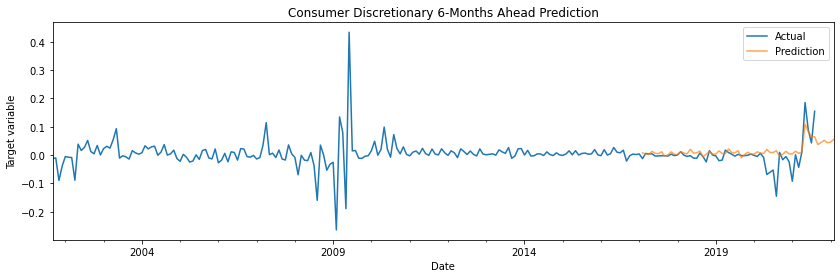

MAPE: 3.131
MAE: 0.02


In [64]:
sar6_pred_mean = sar6_pred.predicted_mean
sar6_pred_ci = sar6_pred.conf_int()
ax = df_6.target.plot(label='Actual')
sar6_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 6-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar6_pred_mean[sar6_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar6_pred_mean[sar6_pred_mean.index < last_date]), 3))

## SARIMAX Model - 12 month

In [65]:
var_corr_12 = (df_12.corr().sort_values('target'))
var_corr_12.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
emp_yoy_ch_1,-0.337812,-0.087308,0.856790,0.249113,0.005522,0.459691,-0.020953,0.020502,0.363371,-0.004880,...,-0.087061,-0.091648,-0.095016,-0.097010,-0.094844,-0.086811,-0.080541,-0.075533,-0.070235,0.003413
emp_yoy_ch,-0.295723,0.309122,1.000000,0.278947,0.224962,0.524064,-0.003139,0.139245,0.399808,0.012553,...,-0.095409,-0.098755,-0.100727,-0.098517,-0.090411,-0.084079,-0.079018,-0.073667,-0.072341,0.000903
emp_yoy_ch_2,-0.254766,-0.098024,0.705579,0.215528,-0.086261,0.361382,-0.042366,-0.054876,0.297569,-0.026842,...,-0.072419,-0.078109,-0.082290,-0.085712,-0.088282,-0.086622,-0.079559,-0.073966,-0.069897,-0.000583
soc_1,-0.250923,0.002709,0.366180,0.434465,0.052908,0.245818,0.033036,0.078719,0.054339,-0.025778,...,0.259515,0.244451,0.228365,0.212157,0.197360,0.184001,0.169347,0.154240,0.139670,-0.077570
emp_yoy_ch_4,-0.225103,-0.032039,0.517023,0.163772,-0.131121,0.112002,-0.113538,-0.101753,0.136916,-0.100179,...,-0.038197,-0.044545,-0.048230,-0.053594,-0.058920,-0.063967,-0.068936,-0.069605,-0.064891,-0.015654


In [66]:
var_corr_12.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
unemp,0.268575,-0.217506,-0.554299,-0.565681,-0.139764,-0.478164,0.018238,-0.088452,-0.318537,0.053233,...,-0.290913,-0.282845,-0.274337,-0.267879,-0.265981,-0.262206,-0.258312,-0.256264,-0.252197,-0.014820
unemp_yoy_ch,0.270288,-0.196209,-0.895750,-0.311198,-0.288515,-0.524167,-0.197699,-0.169943,-0.334717,-0.207210,...,0.221842,0.221672,0.219072,0.213390,0.205180,0.198638,0.193478,0.191738,0.193343,0.023010
unemp_1,0.292828,0.138606,-0.465085,-0.529483,-0.005595,-0.442057,0.027783,-0.006478,-0.295180,0.063133,...,-0.300937,-0.294722,-0.286671,-0.278186,-0.271735,-0.269814,-0.266029,-0.262127,-0.260061,0.002477
unemp_yoy_ch_1,0.297173,-0.031268,-0.805412,-0.304822,-0.137944,-0.479665,-0.174667,-0.087241,-0.314753,-0.185352,...,0.217607,0.220638,0.220488,0.217913,0.212268,0.204106,0.197603,0.192476,0.190755,0.005920
target,1.000000,0.048948,-0.295723,-0.171384,0.049266,-0.150938,-0.020822,0.134185,-0.081821,-0.014925,...,-0.024086,-0.020994,-0.021984,-0.016564,-0.016048,-0.014752,-0.011425,-0.008746,-0.010261,0.004023


In [67]:
model_exvar = ['emp_yoy_ch_1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_12.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_12.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
#print(results.summary())

sar12_model = SARIMAX(y_train, 
                order = (3,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar12_mod_fit = sar12_model.fit()

sar12_pred = sar12_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test
                                         )

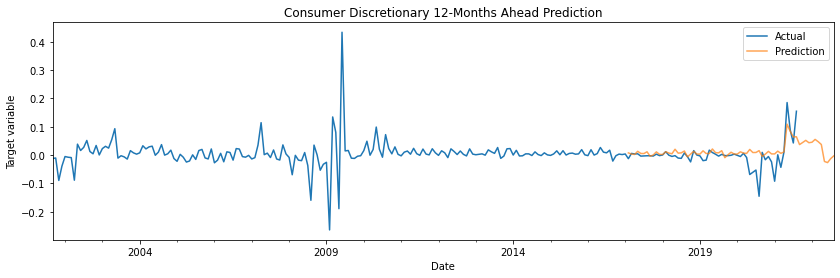

MAPE: 3.131
MAE: 0.02


In [68]:
sar12_pred_mean = sar12_pred.predicted_mean
sar12_pred_ci = sar12_pred.conf_int()
ax = df_12.target.plot(label='Actual')
sar12_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 12-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar12_pred_mean[sar12_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar12_pred_mean[sar12_pred_mean.index < last_date]), 3))

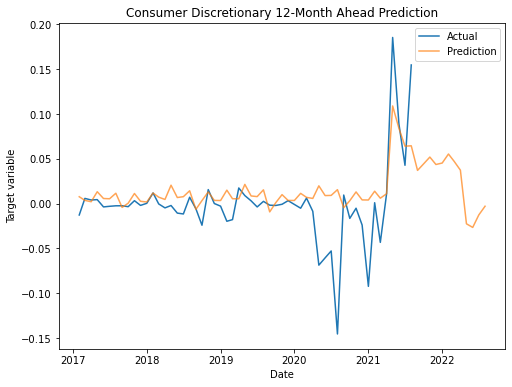

In [69]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_12[df_12.index >= first_date].index, df_12[df_12.index >= first_date].target, label = 'Actual')
ax.plot(sar12_pred_mean.index, sar12_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 12-Month Ahead Prediction')
plt.legend()
plt.show()

## SARIMAX Model - 18 month

In [70]:
var_corr_18 = (df_18.corr().sort_values('target'))
var_corr_18.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
soc_1,-0.179806,0.007147,0.380027,0.371406,0.044097,0.237868,-0.047466,0.088904,0.098346,-0.105624,...,0.304989,0.290500,0.275054,0.259486,0.245228,0.232320,0.218214,0.203685,0.189656,0.042048
soc_yoy_ch,-0.167456,0.142335,0.374850,0.043342,0.088579,-0.026375,0.092447,0.014425,-0.283233,0.086249,...,-0.219629,-0.231712,-0.242887,-0.249989,-0.254166,-0.258090,-0.261807,-0.265031,-0.269389,0.009417
soc_yoy_ch_1,-0.167450,0.024633,0.367745,0.041703,-0.046278,-0.042545,0.082559,0.027994,-0.244746,0.077166,...,-0.204348,-0.216923,-0.228991,-0.240152,-0.247256,-0.251446,-0.255383,-0.259115,-0.262358,0.004973
soc,-0.165627,0.104462,0.396481,0.379185,0.118522,0.228713,-0.036526,0.063773,0.062157,-0.095307,...,0.282778,0.267216,0.251525,0.237161,0.224166,0.209955,0.195322,0.181204,0.166436,0.065384
soc_mom_ch_10,-0.150174,0.017490,0.140908,0.023483,-0.022722,0.059853,0.014582,0.000783,0.001593,0.015275,...,-0.029977,-0.037779,-0.040385,-0.045525,-0.047499,-0.046893,-0.046087,-0.047205,-0.047716,-0.118570


In [71]:
var_corr_18.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
unemp_mom_ch_3,0.168621,0.075346,-0.181267,-0.111223,0.040276,-0.111575,-0.091346,0.011222,-0.063570,-0.091582,...,0.067326,0.062846,0.067470,0.071810,0.077212,0.079163,0.072972,0.064016,0.069265,-0.030823
unemp_mom_ch_11,0.173264,-0.012757,-0.349919,-0.112042,-0.041556,-0.198102,-0.055707,-0.012549,-0.119576,-0.057866,...,0.057211,0.063594,0.067845,0.068208,0.067601,0.064388,0.058140,0.054652,0.053304,0.040769
vix_1,0.178408,-0.314313,-0.589356,-0.373993,-0.210518,-0.346023,-0.179837,-0.278707,-0.225603,-0.184025,...,0.094353,0.099601,0.103936,0.108539,0.112000,0.120794,0.130409,0.138028,0.148388,0.012883
unemp_mom_ch,0.209276,-0.854728,-0.185077,-0.121380,-0.339063,-0.086205,-0.106102,-0.229023,-0.037133,-0.103466,...,0.076164,0.081684,0.083255,0.076818,0.067095,0.071948,0.072641,0.071201,0.077755,0.078112
target,1.000000,-0.093417,-0.114850,-0.048102,0.014819,-0.038730,-0.015881,-0.085130,0.042060,-0.006580,...,-0.011425,-0.008746,-0.010261,-0.005148,-0.003410,-0.001784,0.002442,0.007142,0.010347,0.004023


In [72]:
#model_exvar = ['soc_1', 'unemp_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_18.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_18.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
#print(results.summary())

sar18_model = SARIMAX(y_train, 
                order = (3,0,0), 
                seasonal_order = (2,1,0,12)
                #, exog = x_train
                )

sar18_mod_fit = sar18_model.fit()

sar18_pred = sar18_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], # exog = x_test
                                         )

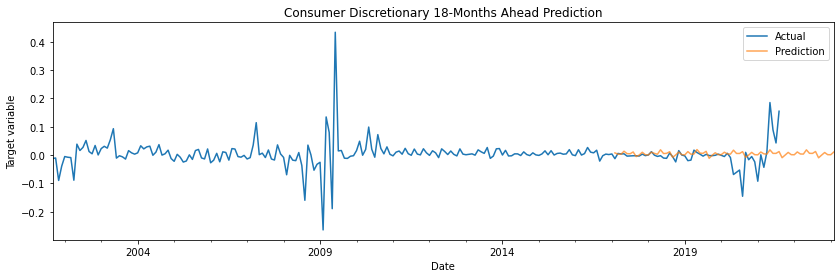

MAPE: 2.541
MAE: 0.023


In [73]:
sar18_pred_mean = sar18_pred.predicted_mean
sar18_pred_ci = sar18_pred.conf_int()
ax = df_18.target.plot(label='Actual')
sar18_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 18-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar18_pred_mean[sar18_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar18_pred_mean[sar18_pred_mean.index < last_date]), 3))

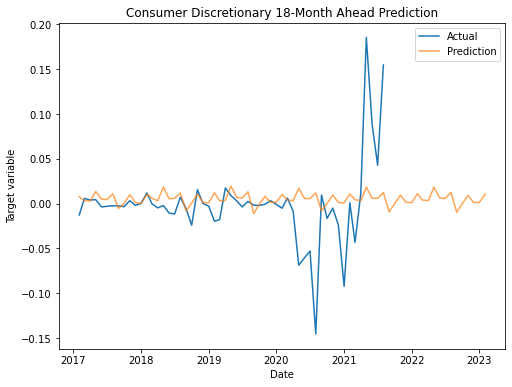

In [74]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_18[df_18.index >= first_date].index, df_18[df_18.index >= first_date].target, label = 'Actual')
ax.plot(sar18_pred_mean.index, sar18_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 18-Month Ahead Prediction')
plt.legend()
plt.show()

## Future Forecast

In [75]:
pred18 = pd.DataFrame(sar18_pred_mean).rename(columns = {'predicted_mean' : 'pred18'})
pred18.index = pred18.index.rename('date')
pred12 = pd.DataFrame(sar12_pred_mean).rename(columns = {'predicted_mean' : 'pred12'})
pred12.index = pred12.index.rename('date')
pred1 = pd.DataFrame(sar1_pred_mean).rename(columns = {'predicted_mean' : 'pred1'})
pred1.index = pred1.index.rename('date')

In [76]:
pred_joined = pred18.join(pred12).join(pred1)
pred_joined

,pred18,pred12,pred1
date,,,
2017-02-01,0.007796,0.007768,0.005810
2017-03-01,0.003264,0.003682,0.005059
2017-04-01,0.003045,0.002199,0.001786
2017-05-01,0.013614,0.013350,0.014184
2017-06-01,0.005128,0.005784,0.008196
...,...,...,...
2022-10-01,-0.000017,NaN,NaN
2022-11-01,0.009127,NaN,NaN
2022-12-01,0.001488,NaN,NaN


In [77]:
pred_joined['combined_pred'] = pred_joined.pred1.fillna(pred_joined.pred12).fillna(pred_joined.pred18)
pred_joined

,pred18,pred12,pred1,combined_pred
date,,,,
2017-02-01,0.007796,0.007768,0.005810,0.005810
2017-03-01,0.003264,0.003682,0.005059,0.005059
2017-04-01,0.003045,0.002199,0.001786,0.001786
2017-05-01,0.013614,0.013350,0.014184,0.014184
2017-06-01,0.005128,0.005784,0.008196,0.008196
...,...,...,...,...
2022-10-01,-0.000017,NaN,NaN,-0.000017
2022-11-01,0.009127,NaN,NaN,0.009127
2022-12-01,0.001488,NaN,NaN,0.001488


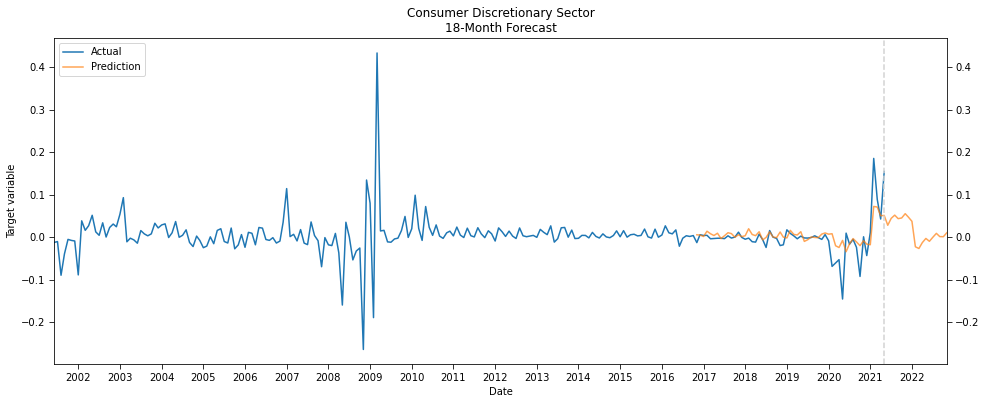

In [79]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# plot inputs
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_18.index, df_18.target, label = 'Actual')
ax.plot(pred_joined.index, pred_joined.combined_pred, label='Prediction', alpha=.7)
ax.axvline(df_18.dropna().index[-1], c = 'lightgrey', linestyle = '--')

# format the axes
ax.xaxis.set_major_formatter(DateFormatter("%Y")) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 12))

ax.yaxis.set_ticks_position('both')
ax.tick_params(length = 5, axis = 'both', labelright = True, direction = 'out')

ax.margins(x=0) # remove whitespace

# labels
ax.set(xlabel = 'Date', ylabel = 'Target variable', 
       title = 'Consumer Discretionary Sector\n18-Month Forecast')

plt.legend()
plt.show()